# 네이버 데이터랩 오픈 API 이용해 일별, 월별 검색어 트렌드 그래프 그리기

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import urllib.request
import datetime
import json
import glob
import sys
import os

from fbprophet import Prophet

import warnings                                # 경고 메시지 무시
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.grid'] = False

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

pd.options.display.float_format = '{:.2f}'.format


class NaverDataLabOpenAPI():
    """
    네이버 데이터랩 오픈 API 컨트롤러 클래스
    """

    def __init__(self, client_id, client_secret):
        """
        인증키 설정 및 검색어 그룹 초기화
        """
        self.client_id = client_id
        self.client_secret = client_secret
        self.keywordGroups = []
        self.url = "https://openapi.naver.com/v1/datalab/search"

    def add_keyword_groups(self, group_dict):
        """
        검색어 그룹 추가
        """

        keyword_gorup = {
            'groupName': group_dict['groupName'],
            'keywords': group_dict['keywords']
        }
        
        self.keywordGroups.append(keyword_gorup)
        print(f">>> Num of keywordGroups: {len(self.keywordGroups)}")


    def get_data(self, startDate, endDate, timeUnit, device, ages, gender):
        """
        요청 결과 반환
        """

        # Request body
        body = json.dumps({
            "startDate": startDate,
            "endDate": endDate,
            "timeUnit": timeUnit,
            "keywordGroups": self.keywordGroups,
            "device": device,
            "ages": ages,
            "gender": gender
        }, ensure_ascii=False)
        
        # Results
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id",self.client_id)
        request.add_header("X-Naver-Client-Secret",self.client_secret)
        request.add_header("Content-Type","application/json")
        response = urllib.request.urlopen(request, data=body.encode("utf-8"))
        rescode = response.getcode()
        if(rescode==200):
            # Json Result
            result = json.loads(response.read())
            
            df = pd.DataFrame(result['results'][0]['data'])[['period']]
            for i in range(len(self.keywordGroups)):
                tmp = pd.DataFrame(result['results'][i]['data'])
                tmp = tmp.rename(columns={'ratio': result['results'][i]['title']})
                df = pd.merge(df, tmp, how='left', on=['period'])
            self.df = df.rename(columns={'period': '날짜'})
            self.df['날짜'] = pd.to_datetime(self.df['날짜'])
            
        else:
            print("Error Code:" + rescode)
            
        return self.df

    def plot_daily_trend(self):
        """
        일 별 검색어 트렌드 그래프 출력
        """
        colList = self.df.columns[1:]
        n_col = len(colList)

        fig = plt.figure(figsize=(12,6))
        plt.title('일 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=self.df['날짜'], y=self.df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')

        
        return fig

    def plot_monthly_trend(self):
        """
        월 별 검색어 트렌드 그래프 출력
        """
        df = self.df.copy()
        df_0 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(0).reset_index().rename(columns={'날짜': '월'})
        df_1 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(1).reset_index().rename(columns={'날짜': '년도'})

        df = pd.merge(df_1[['년도']], df_0, how='left', left_index=True, right_index=True)
        df['날짜'] = pd.to_datetime(df[['년도','월']].assign(일=1).rename(columns={"년도": "year", "월":'month','일':'day'}))
        
        colList = df.columns.drop(['날짜','년도','월'])
        n_col = len(colList)
                
        fig = plt.figure(figsize=(12,6))
        plt.title('월 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=df['날짜'], y=df[colList[i]], label=colList[i])
        plt.legend(bbox_to_anchor=(1.15, 1))  # 범례 상자 외부로 이동
        
        return fig

keyword_group_set = {
    'keyword_group_1': {'groupName': "메가커피", 'keywords': ["메가커피","MEGACOFFE","megacoffee"]},
    'keyword_group_2': {'groupName': "이디야", 'keywords': ["이디야","EDIYA","ediya"]},
    'keyword_group_3': {'groupName': "빽다방", 'keywords': ["빽다방","PAIK'SCOFFEE","Paik'scoffee"]},
    'keyword_group_4': {'groupName': "컴포즈커피", 'keywords': ["컴포즈커피","COMPOSECOFFEE","composecoffee"]},
    'keyword_group_5': {'groupName': "더벤티", 'keywords': ["더벤티","THEVENTI","theventi"]}
}


# API 인증 정보 설정
client_id = "D7jLV6VCs4lIXYM8XqmX"
client_secret = "Zi_dUGUEzQ"

# 요청 파라미터 설정
startDate = "2020-01-01"
endDate = "2021-10-25"
timeUnit = 'date'
device = ''
ages = []
gender = ''

# 데이터 프레임 정의
naver = NaverDataLabOpenAPI(client_id=client_id, client_secret=client_secret)

naver.add_keyword_groups(keyword_group_set['keyword_group_1'])
naver.add_keyword_groups(keyword_group_set['keyword_group_2'])
naver.add_keyword_groups(keyword_group_set['keyword_group_3'])
naver.add_keyword_groups(keyword_group_set['keyword_group_4'])
naver.add_keyword_groups(keyword_group_set['keyword_group_5'])

df = naver.get_data(startDate, endDate, timeUnit, device, ages, gender)

df.head()

>>> Num of keywordGroups: 1
>>> Num of keywordGroups: 2
>>> Num of keywordGroups: 3
>>> Num of keywordGroups: 4
>>> Num of keywordGroups: 5


날짜  메가커피  이디야  빽다방  컴포즈커피  더벤티
0 2020-01-01 11.69 9.75 5.78    2.35 1.95
1 2020-01-02 12.66 8.52 5.69    2.27 1.95
2 2020-01-03 12.36 8.82 5.66    2.54 2.08
3 2020-01-04 12.44 9.06 6.33    2.44 2.22
4 2020-01-05 12.19 8.75 6.25    2.46 2.25

# 중저가 카페 브랜드 - 일 별 검색어 트렌드 

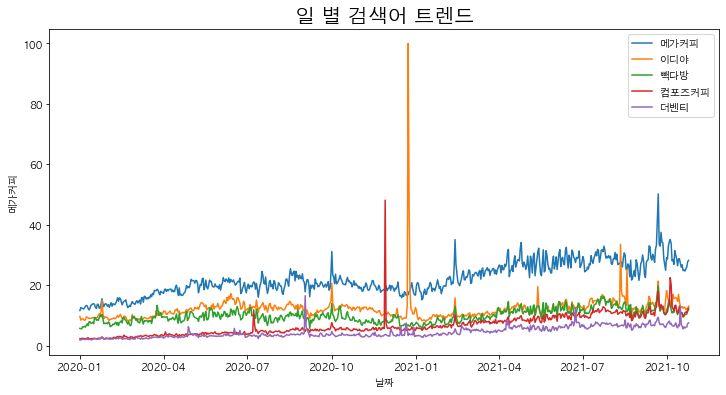

In [24]:
fig_1 = naver.plot_daily_trend()

# 중저가 카페 브랜드 - 월 별 검색어 트렌드

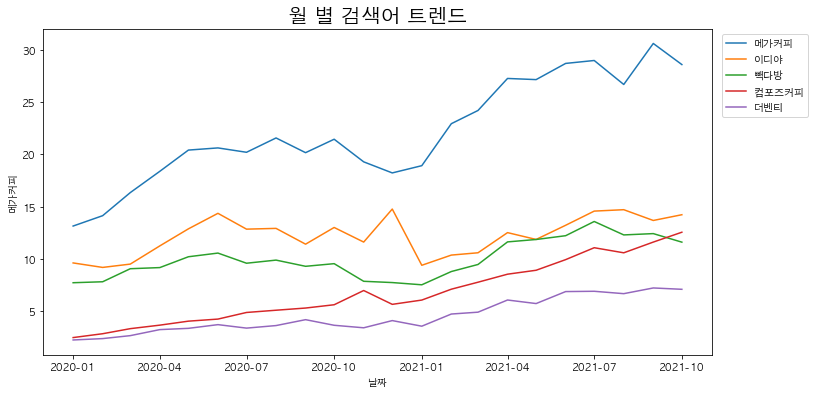

In [25]:
fig_2 = naver.plot_monthly_trend()

##### 일 별 검색어 트렌드 분석
일 별 검색어 트렌드를 보면, 2020-01부터 메가커피의 검색량은 점점 증가한다.
반면 이디야는 오히려 감소하거나 그대로인 형태를 보여, 타 중저가 브랜드 카페인 
빽다방, 컴포즈커피, 더벤티와 격차가 줄고, 메가커피와의 격차가 커졌다.

##### 월 별 검색어 트렌드 분석
월 별 검색어 트렌드를 보면, 카페별 검색량 변화 추이가 더 잘 보인다. 
특히 2021-01부터 메가커피의 검색량이 큰 비율로 증가하면서 1위인 메가커피와 2위인 이디야의 차이가 2배 가량 차이나는 것을 볼 수 있다.